In [1]:
import pandas as pd

# Load the parquet file into a Pandas dataframe
df = pd.read_parquet("s3://nlp-dat/cleaned-data.parquet", engine="pyarrow")

# Show the dataframe
print(df)

      main_category                                              title  \
1        All Beauty  Oral-B Power Tip Premium Rechargeable Power To...   
3        All Beauty  Original Six Gun Chili Mixins Spice Mix, 4 Oun...   
27       All Beauty  Prima Wipes Adult Washcloths, 48 Extra-large W...   
32       All Beauty  Clayton Shagal Collagen Gel 1.7oz by CLAYTON S...   
34       All Beauty  Coxo Obturation System C-Fill a Pack 4 Tips Do...   
...             ...                                                ...   
23985      Handmade                Aztec Death Whistle - Apex Predator   
23987      Handmade  Bridal Shower Table Decorations, Engagement Pa...   
23993      Handmade  Personalized wedding coffee cups sleeves the p...   
23997      Handmade  Tricolor Love Knot Everyday Dangle Earrings wi...   
23998      Handmade  Red Jasper Stud Earrings 6mm Round in Sterling...   

       average_rating  rating_number  \
1                 3.0             10   
3                 4.7          

In [2]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
from peft import get_peft_model, LoraConfig, TaskType
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset
import numpy as np


# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['main_category'])

# Split the dataset into train, validation, and test sets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['content'].tolist(), df['label'].tolist(), test_size=0.3, random_state=42
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42
)

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create Dataset class
class ProductDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors="pt",
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Prepare datasets
train_dataset = ProductDataset(train_texts, train_labels, tokenizer)
val_dataset = ProductDataset(val_texts, val_labels, tokenizer)
test_dataset = ProductDataset(test_texts, test_labels, tokenizer)

# Define hyperparameter grid
hyperparameter_grid = [
    {
        'learning_rate': 5e-5,
        'per_device_train_batch_size': 16,
        'per_device_eval_batch_size': 16,
        'num_train_epochs': 3,
        'weight_decay': 0.01
    },
    {
        'learning_rate': 3e-5,
        'per_device_train_batch_size': 32,
        'per_device_eval_batch_size': 32,
        'num_train_epochs': 4,
        'weight_decay': 0.05
    },
    #{
        #'learning_rate': 2e-5,
        #'per_device_train_batch_size': 16,
        #'per_device_eval_batch_size': 16,
        #'num_train_epochs': 5,
        #'weight_decay': 0.1
    #}
]

# Load pre-trained BERT model
model_base = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', num_labels=len(label_encoder.classes_)
)

# Apply LoRA
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,  # Low-rank dimension
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["bert.encoder.layer.0.attention.self.query", "bert.encoder.layer.0.attention.self.key"]
)
model_base = get_peft_model(model_base, lora_config)

best_hyperparameters = None
best_eval_score = float('inf')  # Change to track the lowest loss

for i, params in enumerate(hyperparameter_grid):
    print(f"Evaluating hyperparameters set {i + 1}...")

    # Define training arguments
    training_args = TrainingArguments(
        output_dir=f"./results_{i}",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=params['learning_rate'],
        per_device_train_batch_size=params['per_device_train_batch_size'],
        per_device_eval_batch_size=params['per_device_eval_batch_size'],
        num_train_epochs=params['num_train_epochs'],
        weight_decay=params['weight_decay'],
        logging_dir=f"./logs_{i}",
        logging_steps=10,
        load_best_model_at_end=True,
    )

    # Initialize Trainer
    trainer = Trainer(
        model=model_base,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer
    )

    # Train the model
    trainer.train()

    # Evaluate on validation set
    eval_results = trainer.evaluate()
    print(f"Validation Results for Set {i + 1}:", eval_results)

    # Update best hyperparameters
    if eval_results['eval_loss'] < best_eval_score:  # Check for lowest loss
        best_eval_score = eval_results['eval_loss']
        best_hyperparameters = params

if best_hyperparameters is None:
    print("No improvement found; using the first hyperparameter set by default.")
    best_hyperparameters = hyperparameter_grid[0]

# Now proceed to evaluate the best model
best_training_args = TrainingArguments(
    output_dir="./final_results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=best_hyperparameters['learning_rate'],
    per_device_train_batch_size=best_hyperparameters['per_device_train_batch_size'],
    per_device_eval_batch_size=best_hyperparameters['per_device_eval_batch_size'],
    num_train_epochs=best_hyperparameters['num_train_epochs'],
    weight_decay=best_hyperparameters['weight_decay'],
    logging_dir="./final_logs",
    logging_steps=10,
    load_best_model_at_end=True,
)

final_trainer = Trainer(
    model=model_base,
    args=best_training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer
)

final_trainer.train()

test_results = final_trainer.evaluate()
print("Test Results with Best Hyperparameters:", test_results)

# Save the best model and tokenizer
model_base.save_pretrained("./best_product_category_model")
tokenizer.save_pretrained("./best_product_category_model")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/sagemaker-user/.conda/envs/nlp/lib/python3.9/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Evaluating hyperparameters set 1...


/tmp/ipykernel_1240/974105723.py:120: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.833300,1.832774
2,1.635200,1.664963
3,1.612900,1.633699


Validation Results for Set 1: {'eval_loss': 1.6336987018585205, 'eval_runtime': 8.1069, 'eval_samples_per_second': 174.048, 'eval_steps_per_second': 10.978, 'epoch': 3.0}
Evaluating hyperparameters set 2...


/home/sagemaker-user/.conda/envs/nlp/lib/python3.9/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_1240/974105723.py:120: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.571000,1.604007
2,1.560300,1.586041
3,1.542700,1.573789
4,1.541500,1.572277


Validation Results for Set 2: {'eval_loss': 1.5722770690917969, 'eval_runtime': 8.5858, 'eval_samples_per_second': 164.341, 'eval_steps_per_second': 5.241, 'epoch': 4.0}


/home/sagemaker-user/.conda/envs/nlp/lib/python3.9/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_1240/974105723.py:159: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  final_trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.528900,1.587818
2,1.527300,1.575450
3,1.503200,1.566363
4,1.517100,1.565101


Test Results with Best Hyperparameters: {'eval_loss': 1.5651010274887085, 'eval_runtime': 8.6205, 'eval_samples_per_second': 163.796, 'eval_steps_per_second': 5.22, 'epoch': 4.0}


('./best_product_category_model/tokenizer_config.json',
 './best_product_category_model/special_tokens_map.json',
 './best_product_category_model/vocab.txt',
 './best_product_category_model/added_tokens.json')

/home/sagemaker-user/.conda/envs/nlp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Set Performance:
Accuracy: 0.3909
Precision: 0.3102
Recall: 0.3909
F1-score: 0.3105


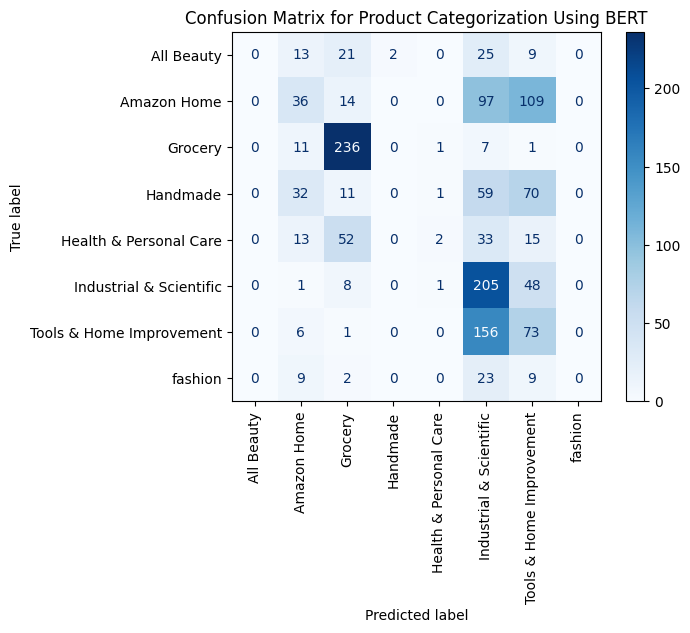

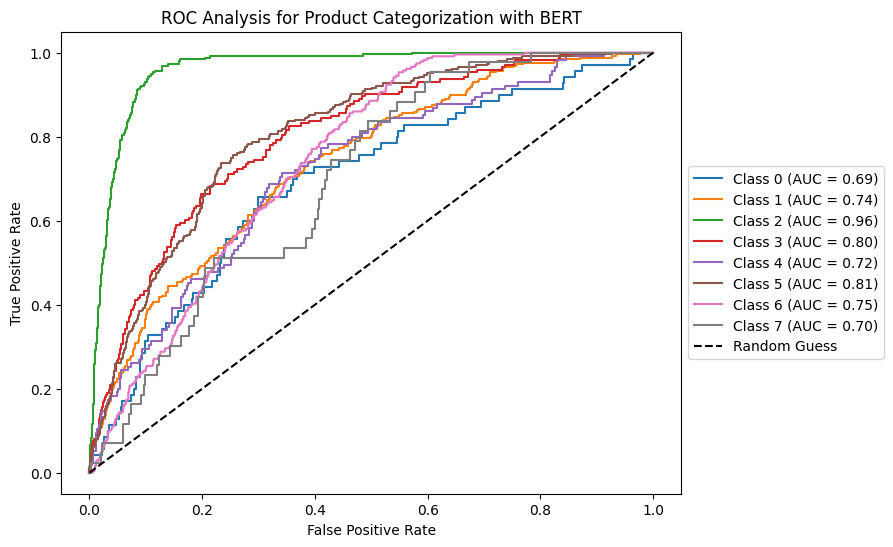

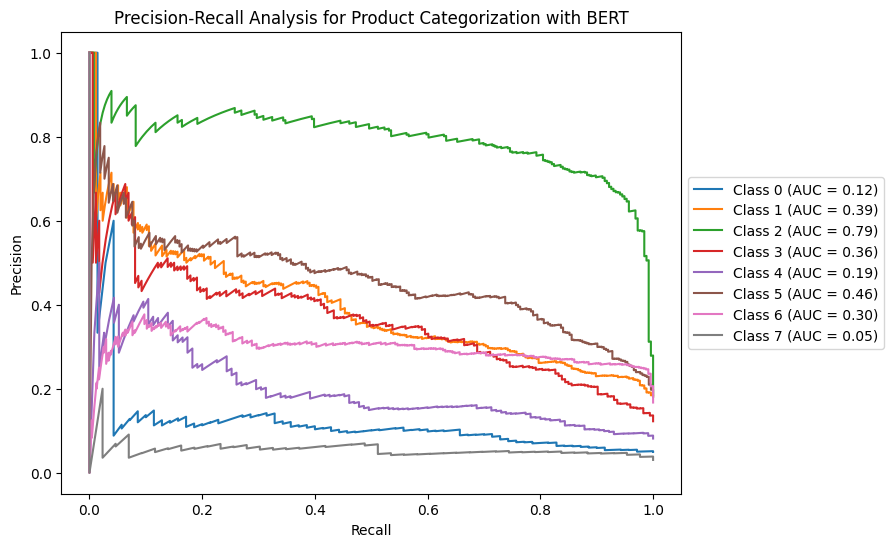

In [11]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_curve, auc, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from transformers import pipeline
import numpy as np

# Define a function to plot ROC curve
def plot_roc_curve(y_true, y_probs, num_classes):
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Analysis for Product Categorization with BERT")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))  # Legend outside plot
    plt.show()

# Define a function to plot Precision-Recall curve
def plot_precision_recall_curve(y_true, y_probs, num_classes):
    precision = {}
    recall = {}
    pr_auc = {}

    for i in range(num_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true == i, y_probs[:, i])
        pr_auc[i] = auc(recall[i], precision[i])

    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(recall[i], precision[i], label=f"Class {i} (AUC = {pr_auc[i]:.2f})")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Analysis for Product Categorization with BERT")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))  # Legend outside plot
    plt.show()

# Evaluate the final model on the test dataset
predictions = final_trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
probs = np.exp(predictions.predictions) / np.sum(np.exp(predictions.predictions), axis=1, keepdims=True)

# Classification metrics
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, preds, average="weighted")
accuracy = accuracy_score(test_labels, preds)

print("Test Set Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(test_labels, preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
cm_display.plot(cmap="Blues")

# Rotate axis labels
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
plt.yticks(rotation=0)   # Keep y-axis labels horizontal 
plt.title("Confusion Matrix for Product Categorization Using BERT")
plt.show()

# Plot ROC Curve
plot_roc_curve(np.array(test_labels), probs, num_classes=len(label_encoder.classes_))

# Plot Precision-Recall Curve
plot_precision_recall_curve(np.array(test_labels), probs, num_classes=len(label_encoder.classes_))